In [415]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph
import torch


In [416]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [417]:
class Value:
  
  def __init__(self, data, label='', _op='', _children=() ):
    self.data = data
    self.label = label
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self._backward = lambda: None

  def adapt_other(self, other):
    if not isinstance(other, Value):
      other = Value(other)
    return other
  
  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = self.adapt_other(other)
    out = Value(self.data + other.data, _children=(self, other), _op='+')
    def _backward():
      self.grad += 1.0*out.grad
      other.grad += 1.0*out.grad
    out._backward = _backward
    return out
  
  def __radd__(self, other):
    return self + other
  
  def __sub__(self, other): # self - other
    return self + (-other)

  def __neg__(self): # -self
    return self * -1
  
  def __mul__(self, other):
    other = self.adapt_other(other)
    out = Value(self.data * other.data, _children=(self, other), _op='*')
    def _backward():
      self.grad += other.data*out.grad
      other.grad += self.data*out.grad
    out._backward = _backward
    return out
  
  def __rmul__(self, other):
    return self * other
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, _children=(self,), _op=f'**{other}')
    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, _children=(self, ), _op='tanh')
    def _backward():
      self.grad += (1 - t**2)*out.grad
    out._backward = _backward
    return out

  def backward(self):
      
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()
      
def get_deriv(get_fcn, deriv=""):
  
  h=0.0001
  deriv_val = (get_fcn(h, deriv=deriv).data - get_fcn(0, deriv=deriv).data) / h
  print(f"deriv_{deriv} = {deriv_val}")
  return deriv_val



  


deriv_a = 6.000000000021544
deriv_b = -4.000000000008441
deriv_c = -1.9999999999953388
deriv_d = -1.9999999999953388
deriv_e = -1.9999999999953388
deriv_f = 3.9999999999995595
deriv_L = 0.9999999999976694


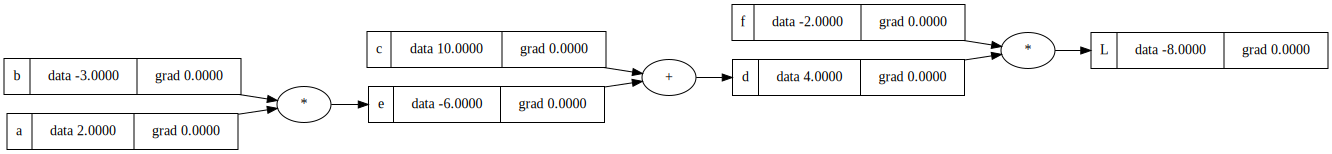

In [418]:
def get_L(h=0.0, deriv=""):
  
  ah=0
  bh=0
  ch=0
  dh=0
  eh=0
  fh=0
  Lh=0
  if h!=0:
    if deriv=="a":
      ah=h
    elif deriv=="b":
      bh=h
    elif deriv=="c":
      ch=h
    elif deriv=="d":
      dh=h
    elif deriv=="e":
      eh=h
    elif deriv=="f":
      fh=h
    elif deriv=="L":
      Lh=h

  a = Value(2.0 + ah, label='a')
  b = Value(-3.0 + bh, label='b')
  c = Value(10.0 + ch, label='c')
  e = a * b; e.label = 'e'; e.data += eh
  d = e + c; d.label = 'd'; d.data += dh
  f = Value(-2.0 + fh, label='f')
  L = d * f; L.label = 'L'; L.data += Lh
  
  return L



get_deriv(get_L,"a")
get_deriv(get_L,"b")
get_deriv(get_L,"c")
get_deriv(get_L,"d")
get_deriv(get_L,"e")
get_deriv(get_L,"f")
get_deriv(get_L,"L")

L = get_L()
draw_dot(L)

deriv_x1 = -1.500318220551966
deriv_x2 = 0.49996464549284525
deriv_w1 = 0.9998585853132624
deriv_w2 = 0.0
deriv_b = 0.49996464549284525
deriv_x1w1 = 0.49996464549284525
deriv_x2w2 = 0.49996464549284525
deriv_x1w1x2w2 = 0.49996464549284525
deriv_n = 0.4999646454939555
deriv_o = 0.9999999999998899


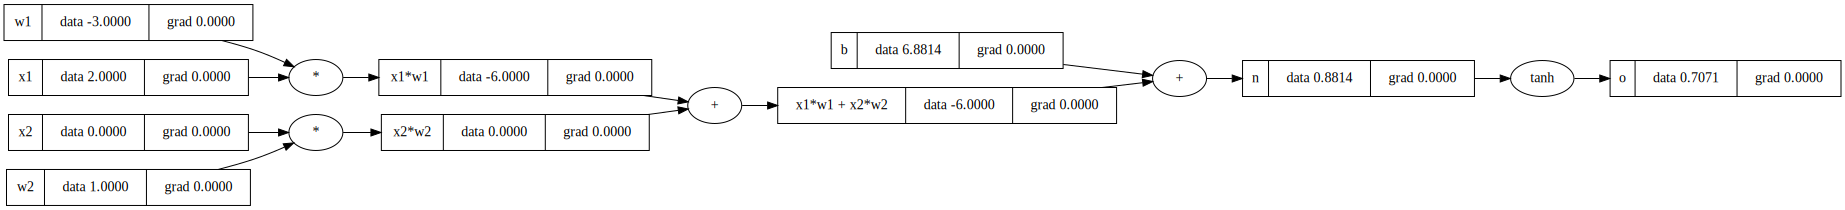

In [419]:
def get_o(h=0.0, deriv=""):
  
  x1h=0
  x2h=0
  w1h=0
  w2h=0
  bh=0
  x1w1h=0
  x2w2h=0
  x1w1x2w2h=0
  nh=0
  oh=0
  if h!=0:
    if deriv=="x1":
      x1h=h
    elif deriv=="x2":
      x2h=h
    elif deriv=="w1":
      w1h=h
    elif deriv=="w2":
      w2h=h
    elif deriv=="b":
      bh=h
    elif deriv=="x1w1":
      x1w1h=h
    elif deriv=="x2w2":
      x2w2h=h
    elif deriv=="x1w1x2w2":
      x1w1x2w2h=h
    elif deriv=="n":
      nh=h
    elif deriv=="o":
      oh=h

  # inputs x1,x2
  x1 = Value(2.0 + x1h, label='x1')
  x2 = Value(0.0 + x2h, label='x2')
  # weights w1,w2
  w1 = Value(-3.0 + w1h, label='w1')
  w2 = Value(1.0 + w2h, label='w2')
  # bias of the neuron
  b = Value(6.8813735870195432 + bh, label='b')
  # x1*w1 + x2*w2 + b
  x1w1 = x1*w1; x1w1.label = 'x1*w1'; x1w1.data += x1w1h
  x2w2 = x2*w2; x2w2.label = 'x2*w2'; x2w2.data += x2w2h
  x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'; x1w1x2w2.data += x1w1x2w2h
  n = x1w1x2w2 + b; n.label = 'n'; n.data += nh
  o = n.tanh(); o.label = 'o'; o.data += oh
    
  return o


get_deriv(get_o, "x1")
get_deriv(get_o, "x2")
get_deriv(get_o, "w1")
get_deriv(get_o, "w2")
get_deriv(get_o, "b")
get_deriv(get_o, "x1w1")
get_deriv(get_o, "x2w2")
get_deriv(get_o, "x1w1x2w2")
get_deriv(get_o, "n")
get_deriv(get_o, "o")

o = get_o()
draw_dot(o)

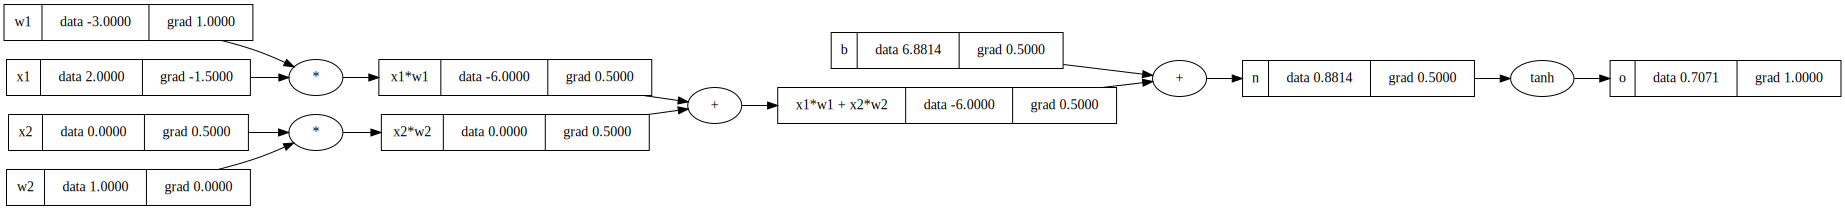

In [420]:
o.backward()
draw_dot(o)

In [421]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [422]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1,1))

    def __call__(self, x):
        act = sum(wi*xi for wi,xi in zip(self.w, x)) + self.b
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    



In [423]:
x = [2.0, 3.0, -1.0]

n = Neuron(3)
n(x)

l = Layer(3, 4)
l(x)

mlp = MLP(3, [4, 4, 1])
mlp(x)

# draw_dot(mlp(x))

Value(data=0.05348951719697815)

In [424]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ys_pred = [mlp(x) for x in xs]
ys_pred

[Value(data=0.05348951719697815),
 Value(data=-0.07999729031809147),
 Value(data=-0.06182566714604418),
 Value(data=0.012541515478055654)]

In [425]:
losses = [((y_p - y_t)**2) for y_p, y_t in zip(ys_pred, ys)]
print(losses)

loss = sum(losses)
print(loss)

loss.backward()

# draw_dot(loss)

[Value(data=0.8958820940560095), Value(data=0.8464049858220541), Value(data=0.880171078825965), Value(data=0.9750742586543749)]
Value(data=3.5975324173584036)


In [428]:
for k in range(1000):

    # forward pass
    ys_pred = [mlp(x) for x in xs]
    loss = sum((y_p - y_t)**2 for y_p, y_t in zip(ys_pred, ys))

    # backward pass
    for p in mlp.parameters():
        p.grad = 0.0
    loss.backward()

    # update	
    for p in mlp.parameters():
        p.data -= p.grad * 0.01

    print(k, loss.data)

ys_pred
    

0 0.0012887915290951991
1 0.0012880935900808407
2 0.0012873963842547971
3 0.0012866999104753276
4 0.0012860041676029882
5 0.0012853091545007036
6 0.0012846148700337424
7 0.0012839213130697038
8 0.0012832284824785267
9 0.001282536377132474
10 0.00128184499590614
11 0.001281154337676399
12 0.001280464401322453
13 0.0012797751857257914
14 0.0012790866897702561
15 0.0012783989123418896
16 0.001277711852329077
17 0.0012770255086224766
18 0.001276339880114996
19 0.001275654965701842
20 0.0012749707642804376
21 0.00127428727475051
22 0.0012736044960139955
23 0.0012729224269750995
24 0.0012722410665402574
25 0.001271560413618122
26 0.0012708804671195924
27 0.001270201225957795
28 0.001269522689048043
29 0.0012688448553078743
30 0.001268167723657036
31 0.0012674912930174535
32 0.0012668155623132816
33 0.0012661405304708238
34 0.0012654661964185874
35 0.0012647925590872433
36 0.0012641196174096644
37 0.0012634473703208194
38 0.0012627758167579025
39 0.0012621049556602623
40 0.0012614347859693491

[Value(data=0.9876102708394405),
 Value(data=-0.9891664509701735),
 Value(data=-0.9850568268008701),
 Value(data=0.9816154832105255)]